# 1.Loading the data and preparing them for analysis

In [818]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [819]:
visits = pd.read_csv('/datasets/visits_log.csv')

In [820]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


There are 5 columns and 349400 rows in the table

In [821]:
visits.head(5)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [822]:
#changing data types in columns
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])

In [823]:
visits.duplicated().sum()

0

In [824]:
visits.isna().sum()

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

No duplicates or nulls were found in the table 

In [825]:
orders = pd.read_csv('/datasets/orders_log.csv')

In [826]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


The orders table has 3 columns and 50415 rows

In [827]:
orders.head(5)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [828]:
#changing data types in columns
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])

In [829]:
orders.duplicated().sum()

0

In [830]:
orders.isna().sum()

Buy Ts     0
Revenue    0
Uid        0
dtype: int64

No duplicates or nulls were found in the table of orders 

In [831]:
costs = pd.read_csv('/datasets/costs.csv')

In [832]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


The costs table has 3 columns and 2,542 rows

In [833]:
costs.head(5)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [834]:
#changing data types in columns
costs['dt'] = pd.to_datetime(costs['dt'])

In [835]:
costs.duplicated().sum()

0

In [836]:
costs.isna().sum()

source_id    0
dt           0
costs        0
dtype: int64

No duplicates or nulls were found in the costs table 

# 2. Building reports and calculating metrics

# How many people use per day, week, month?

In [837]:
# new column at the beginning of the session (what day) 
visits['day'] = visits['Start Ts'].dt.day
#new column at the beginning of the session (which week)
visits['week'] = visits['Start Ts'].dt.week
#new column by the beginning of the session (which month)
visits['month'] = visits['Start Ts'].dt.month
#new column by the beginning of the session(what year)
visits['year'] = visits['Start Ts'].dt.year

In [838]:
# print(visits)
visits_daily = visits.groupby(['year','month','day']).agg({'Uid': 'nunique'})
print('Средняя ежедневная аудитория:',int(visits_daily.mean()),'человек')

Средняя ежедневная аудитория: 907 человек


In [839]:
visits_weekly = visits.groupby('week').agg({'Uid': 'nunique'})
print('Средняя еженедельная аудитория:',int(visits_weekly.mean()),'человек')

Средняя еженедельная аудитория: 5825 человек


In [840]:
visits_monthly = visits.groupby('month').agg({'Uid': 'nunique'})
print('Средняя ежемесячная аудитория:',int(visits_monthly.mean()),'человек')

Средняя ежемесячная аудитория: 23228 человек


# How many sessions per day?

In [841]:
sessions_per_day = visits.groupby(['year','month','day']).agg({'Uid':'count'})
sessions_per_day = sessions_per_day['Uid'].mean().round()
print('Среднее ежедневное количество сессий:',sessions_per_day)

Среднее ежедневное количество сессий: 987.0


# How long does one session last?

In [842]:
visits['duration'] = visits['End Ts'] - visits['Start Ts']
print(visits['duration'].mean())

0 days 00:10:43.025687


On average, one session lasts 10 minutes and 43 seconds

# How often do people come back? (Retention Rate)

In [843]:
#Cut only by user columns and session start
visits_analysis = visits.loc[:,['Uid','Start Ts']]
#making the session start column into a month format
visits_analysis['Start Ts'] = pd.to_datetime(visits_analysis['Start Ts']).astype('datetime64[M]')
#grouping users by first visit
first_visits = visits_analysis.groupby(['Uid'])['Start Ts'].min()

first_visits.name = 'first_visits_month'
#Combining tables by month of attendance and first attendance
visits_analysis = visits_analysis.join(first_visits,on='Uid')
visits_analysis = visits_analysis.rename(columns={'Start Ts':'activity_month'}) 

In [844]:
#For each row of the dataframe we calculate the lifetime of the user within the cohort
visits_analysis['cohort_lifetime'] = visits_analysis['activity_month'] - visits_analysis['first_visits_month']
# as a divisor we refer to the constant np.timedelta64(1,'M')
visits_analysis['cohort_lifetime'] = visits_analysis['cohort_lifetime'] / np.timedelta64(1,'M')

visits_analysis['cohort_lifetime'] = visits_analysis['cohort_lifetime'].astype(float).round()


In [845]:
#group the data by cohort and lifetime. 
#Calculate for each cohort the number of active users for a certain "life month"
cohorts = visits_analysis.groupby(['first_visits_month','cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()
#Find the initial number of users in the cohort. Let's take their number at month zero
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visits_month','Uid']]
#Rename the Uid column to cohort_users
initial_users_count = initial_users_count.rename(columns={'Uid':'cohort_users'})

In [846]:
#combine the cohort data with the initial number of users in the cohort
cohorts = cohorts.merge(initial_users_count,on='first_visits_month')
#Calculate Retention Rate. Divide the number of active users in each of the months by the initial number of users in the cohort
cohorts['retention'] = cohorts['Uid']/cohorts['cohort_users']
#build a pivot table
retention_pivot = cohorts.pivot_table(index='first_visits_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

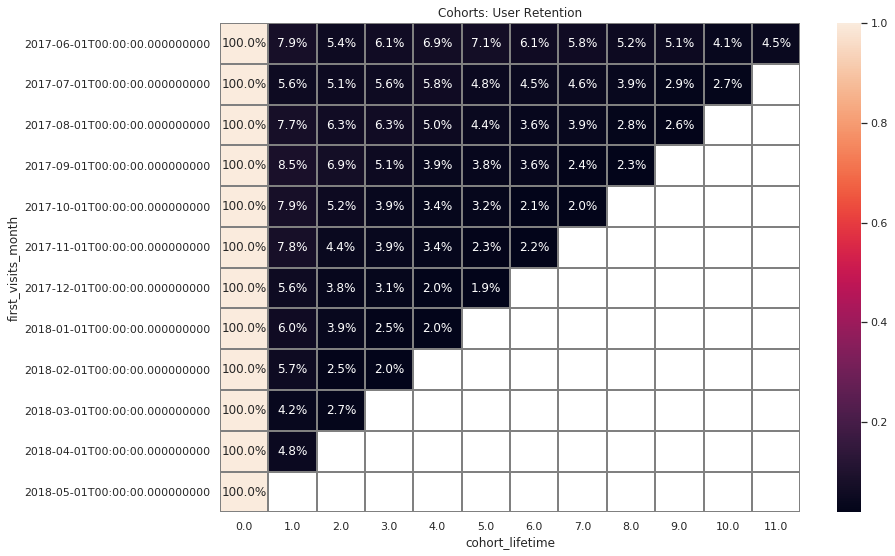

In [847]:
#create a heat map
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

We observe a very low Retention Rate for all cohorts. So, in the second month, the number of unique users who came back does not exceed 8.5%.
Perhaps ineffective traffic sources were chosen or the quality of customer service deteriorated.

# 3.Sales.


# When do people start buying?

In [848]:
#Cut only by user columns and session start
visits_short = visits.loc[:,['Uid', 'Start Ts', 'Source Id']]
#setting the purchase column to date format
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])


In [849]:
#connecting the visit tables and the new table
visits_orders = visits_short.merge(orders, on="Uid")
# renaming columns
visits_orders.columns = ['Uid', 'Start_Ts', 'source_id', 'Buy_Ts', 'Revenue']
#cuts only when purchase time exceeds session start time
visits_orders_final = visits_orders.query('Buy_Ts > Start_Ts')
#new column by the time difference between the purchase and the beginning of the session
visits_orders_final['buy_duration'] = visits_orders_final['Buy_Ts'] - visits_orders_final['Start_Ts']
#grouping by time of purchase and the difference between the time of purchase and the beginning of the session
visits_orders_final = visits_orders_final.groupby('Buy_Ts').agg({'buy_duration':min, 'source_id':'first', 'Uid':'first'})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [886]:
print(visits_orders_final.median())

buy_duration    0 days 00:12:00
source_id                     3
Uid                 9.08239e+18
dtype: object


The average time to start a purchase is 12 minutes

# How many times do they buy in a period?

In [882]:
#convert column to date format
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])

In [883]:
purchases = orders.groupby('Uid').agg({'Buy Ts':'count'}).mean()
print(purchases)

Buy Ts    1.380363
dtype: float64


During this period, on average, each customer makes 1.38 purchases.

# What is the average check?

In [853]:
#slash on all proceeds is greater than 0
orders_not_zero = orders.query('Revenue > 0')
print(orders_not_zero['Revenue'].describe())

count    50364.000000
mean         5.004710
std         21.828823
min          0.010000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: Revenue, dtype: float64


The average check is 5 

# How much money do they bring in? (LTV)

In [854]:
#Check for a match of order date ranges with expense dates.
orders['Buy Ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: Buy Ts, dtype: object

In [855]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

In [856]:
#new column with purchase date by month
orders['order_month'] = orders['Buy Ts'].astype('datetime64[M]')
#new column with the date of expenses by month
costs['month'] = costs['dt'].astype('datetime64[M]')

In [857]:
#get a month of every customer's first purchase
first_orders = orders.groupby('Uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['Uid', 'first_order_month']

In [858]:
#count the number of new buyers (n_buyers) for each month
cohort_sizes = first_orders.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [859]:
#build cohorts. Add the month of each customer's first purchase to the order table
orders_new = pd.merge(orders,first_orders, on='Uid')

In [860]:
#group the order table by the month of first purchase and the month of each order and add up the revenue.
cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'Revenue': 'sum'}).reset_index()
cohorts

,first_order_month,order_month,Revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


In [861]:
#Add data to the cohorts table about how many people made their first purchase in each month
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [862]:
#take the margin as 100%
margin_rate = 1
#build "age" cohorts   
report['gp'] = report['Revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [863]:
#find LTV
report['ltv'] = report['gp'] / report['n_buyers']
report

,first_order_month,n_buyers,order_month,Revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531
...,...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0,4.657597
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1,0.531599
77,2018-05-01,2988,2018-05-01,13925.76,13925.76,0,4.660562


In [864]:
#visualize the cohorts as a summary table
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
output_ltv = output.cumsum(axis=1).round(2)

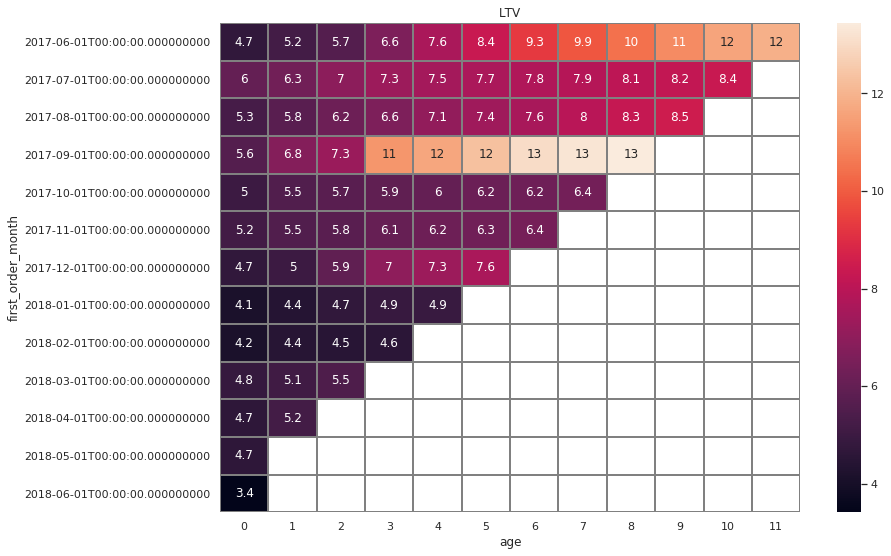

In [865]:
#create a heat map
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(output_ltv, annot=True, linewidths=1, linecolor='gray');

In [866]:
#Let's calculate the total LTV of the first cohort. Add up their LTV by month:
ltv_201706 = output.loc['2017-06-01'].sum()
print(ltv_201706)

11.879233811171527


On average, each customer in the first cohort brought in 11.9 revenue in 12 months of "life

# 4.Marketing
# How much money did you spend? Total / per source / per time

In [867]:
#Total
costs_total = costs['costs'].sum()
print('Всего потратили:',costs_total)

Всего потратили: 329131.62


In [868]:
#for every source
costs_by_source = costs.groupby(['source_id']).agg({'costs': 'sum'}).reset_index()
costs_by_source.sort_values(by='costs',ascending=False)

,source_id,costs
2,3,141321.63
3,4,61073.60
4,5,51757.10
1,2,42806.04
0,1,20833.27
6,10,5822.49
5,9,5517.49


The most was spent for the 3rd advertising source (141321.63), which is more than twice as much as for the 4th source after it (61073.6). It should be noted the low expenses for the 10th and 9th advertising source (5823 and 5518, respectively)

In [869]:
#by month
costs_month = costs.groupby('month').agg({'costs':'sum'})
costs_month

,costs
month,
2017-06-01,18015.00
2017-07-01,18240.59
2017-08-01,14790.54
2017-09-01,24368.91
2017-10-01,36322.88
2017-11-01,37907.88
2017-12-01,38315.35
2018-01-01,33518.52
2018-02-01,32723.03


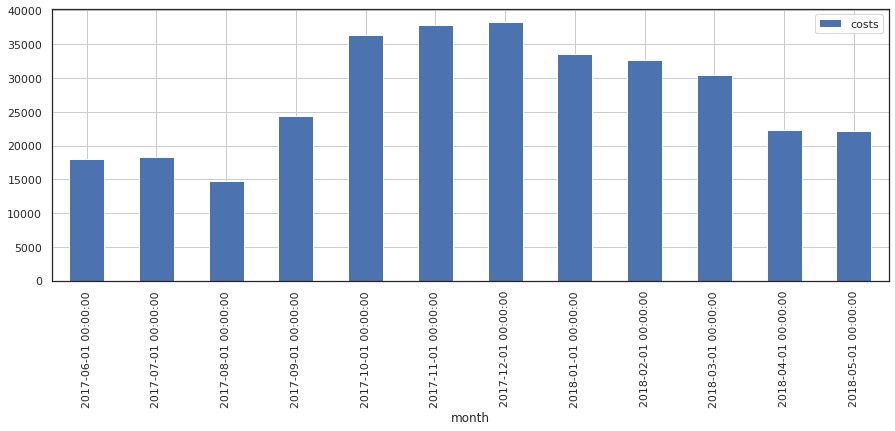

In [870]:
costs_month.plot(figsize=(15,5),grid=True,kind='bar')

We see an increase in marketing expenses towards the end of the year. Thus, the biggest expenses are in December (38315.35). At the same time, we see the lowest spending in the summer months. The lowest expenses are in August(14790.54)

# How much does it cost to attract one customer from each source?

In [871]:
#returning to the previously obtained merged buyers table
visits_orders_final

,buy_duration,source_id,Uid
Buy_Ts,,,
2017-06-01 00:10:00,0 days 00:01:00,1,10329302124590727494
2017-06-01 00:25:00,0 days 00:11:00,2,11627257723692907447
2017-06-01 00:27:00,0 days 00:02:00,2,17903680561304213844
2017-06-01 00:29:00,0 days 00:15:00,2,16109239769442553005
2017-06-01 07:58:00,0 days 00:27:00,3,14200605875248379450
...,...,...,...
2018-05-31 23:43:00,0 days 01:08:00,2,1805512004303848280
2018-05-31 23:50:00,0 days 00:04:00,4,12296626599487328624
2018-05-31 23:54:00,0 days 00:02:00,3,1786462140797698849


In [872]:
#grouping by advertising sources of the number of unique buyers
users_by_source = visits_orders_final.groupby('source_id').agg({'Uid':'nunique'})
users_by_source

,Uid
source_id,
1,3411
2,3606
3,8703
4,9128
5,6354
7,1
9,1022
10,1138


In [873]:
#general table of unique users and advertising sources + costs (by month)
users_costs_per_source = users_by_source.merge(costs_by_source, on='source_id')
users_costs_per_source

,source_id,Uid,costs
0,1,3411,20833.27
1,2,3606,42806.04
2,3,8703,141321.63
3,4,9128,61073.60
4,5,6354,51757.10
5,9,1022,5517.49
6,10,1138,5822.49


In [874]:
#new column for cost per user by month and advertising sources
users_costs_per_source['costs_per_buyer'] = users_costs_per_source['costs']/users_costs_per_source['Uid']
users_costs_per_source.sort_values(by='costs_per_buyer', ascending=False)

,source_id,Uid,costs,costs_per_buyer
2,3,8703,141321.63,16.238266
1,2,3606,42806.04,11.870782
4,5,6354,51757.10,8.145593
3,4,9128,61073.60,6.690798
0,1,3411,20833.27,6.107672
5,9,1022,5517.49,5.398718
6,10,1138,5822.49,5.116424


We see that the most costly advertising source to attract one user is the third source(16.2). The second advertising source also has a high index (11.9). In contrast, the lowest cost per new customer is characterized by the 10th and 9th advertising sources (5.12 and 5.4, respectively).

# Attracting new users by device

In [875]:
devices_by_sources = visits.pivot_table(index="Device", columns='Source Id', values="Uid", aggfunc="nunique")
devices_by_sources

Source Id,1,2,3,4,5,6,7,9,10
Device,,,,,,,,,
desktop,13172,18257,57420,55607,42053,5,26,7079,5763
touch,6094,8609,18600,29313,15375,1,8,2402,2381


We can see that there are several times more new users coming from personal computers than from mobile devices. This indicates a weak mobile application (if any), or poor optimization of the mobile version of the site for the user

# How much did the costs pay off? (ROI)

In [876]:
#Add expense data to the report and calculate CAC
report_new = pd.merge(report, costs_month, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new

,first_order_month,n_buyers,order_month,Revenue,gp,age,ltv,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414,18015.00,8.905091
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329,18015.00,8.905091
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637,18015.00,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671,18015.00,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531,18015.00,8.905091
...,...,...,...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,1063.05,1,0.300892,30415.27,8.608907
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559,30415.27,8.608907
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0,4.657597,22289.38,9.793225
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1,0.531599,22289.38,9.793225


In [877]:
#Calculate ROI: Divide LTV by CAC
report_new['roi'] = report_new['ltv'] / report_new['cac']
#create the ROI summary table
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='roi', 
        aggfunc='mean')
#calculate cumulative ROI
output_a = output.cumsum(axis=1).round(2)

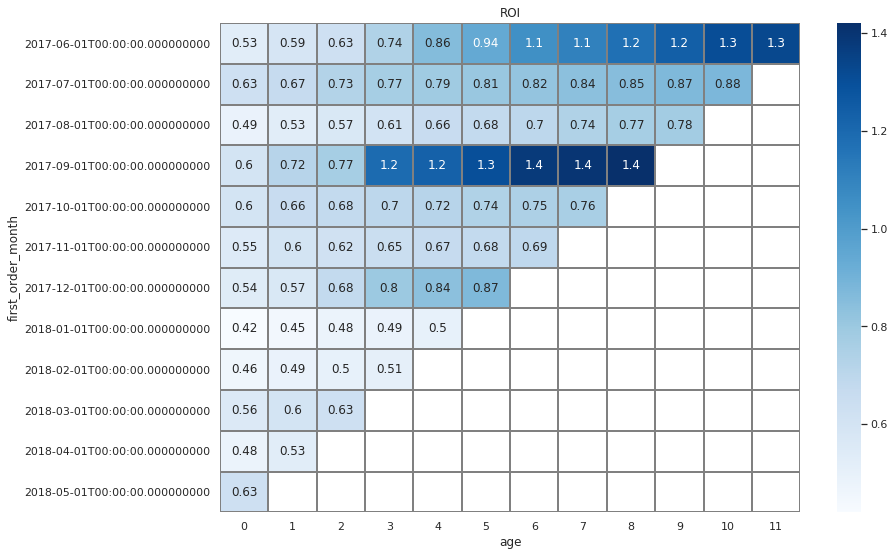

In [878]:
#create a heat map
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROI')
sns.heatmap(output_a , annot=True, linewidths=1, linecolor='gray', cmap="Blues");

The September cohort paid off in month 4 (ROI = 1.2). The June cohort paid off in month 7 (ROI = 1.1). These are the only cohorts that paid off

In [879]:
#calculate average 
output.cumsum(axis=1).mean(axis=0)

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

On average, a cohort begins to pay for itself after the 11th month

# General Conclusion

According to the results of the analysis we can draw the following conclusions:
1. I recommend to pay attention to the low level of new users from mobile devices relative to personal computers. Perhaps there are problems with the mobile application (if any), or poor optimization of the mobile version of the site for the user.
2. First of all pay attention to 9 and 10 advertising sources. They are naimenie costly of all advertising sources (5518 and 5823, respectively), but they have the lowest rate of cost per new customer (5.12 and 5.4, respectively).
3. Revise your budget for the 3 advertising sources. As for investments, it's on the first place(141321.63), which is more than twice as much as the costs of the next source after it(61073.6). At the same time it is the most "expensive" advertising source in terms of attracting new users.
4. We observe a very low Retention Rate for all cohorts. So, in the second month, the number of unique users who come back repeatedly does not exceed 9%, while there is a slight increase in all cohorts in February 2018. Perhaps ineffective traffic sources were selected or the quality of customer service has deteriorated.
5. We also see low LTV(lifetime value). On average, each customer in the first cohort(those who came to the site in June 2017) brought in 11.9 revenue in 12 months of "lifetime", which is less than 1 per month on average.
6. As for ROI (Return On Investment),the September cohort paid off in 4 months (ROI = 1.2). The June cohort paid off in the 7th month (ROI = 1.1). These are the only cohorts that have paid off. The average cohort begins to pay for itself after the 11th month